In [4]:
from google.colab import files
files.upload()

Saving NFLX.csv to NFLX.csv


{'NFLX.csv': b'Date,Open,High,Low,Close,Adj Close,Volume\n2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000\n2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800\n2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400\n2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800\n2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200\n2002-05-31,1.078571,1.078571,1.071429,1.076429,1.076429,8464400\n2002-06-03,1.080000,1.149286,1.076429,1.128571,1.128571,3151400\n2002-06-04,1.135714,1.140000,1.110714,1.117857,1.117857,3105200\n2002-06-05,1.110714,1.159286,1.107143,1.147143,1.147143,1531600\n2002-06-06,1.150000,1.232143,1.148571,1.182143,1.182143,2305800\n2002-06-07,1.177857,1.177857,1.103571,1.118571,1.118571,1369200\n2002-06-10,1.135000,1.175000,1.134286,1.156429,1.156429,484400\n2002-06-11,1.156429,1.188571,1.128571,1.153571,1.153571,1003800\n2002-06-12,1.153571,1.182143,1.089286,1.092857,1.092857,1799000\n2002-06-13,1.104286,1.122143,

In [5]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
df = pd.read_csv('/content/NFLX.csv')
df.tail()

Date        Open        High         Low       Close   Adj Close  \
4869  2021-09-24  592.500000  592.979980  583.640015  592.390015  592.390015   
4870  2021-09-27  587.950012  593.580017  576.929993  592.640015  592.640015   
4871  2021-09-28  589.000000  599.539978  580.159973  583.849976  583.849976   
4872  2021-09-29  589.010010  609.880005  588.010010  599.059998  599.059998   
4873  2021-09-30  608.049988  619.000000  608.049988  610.340027  610.340027   

       Volume  
4869  2124800  
4870  2504700  
4871  4431100  
4872  6221000  
4873  6612600

In [7]:
# menghapus kolom yang tidak digunakan

df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
df.head()

Date     Close
0  2002-05-23  1.196429
1  2002-05-24  1.210000
2  2002-05-28  1.157143
3  2002-05-29  1.103571
4  2002-05-30  1.071429

In [8]:
# mengambil data dari tahun 2010 sampai 2020

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
fd = (df['Date'] >= '2010-01-01') & (df['Date'] <= '2020-12-31')
df.loc[fd]
df = df.loc[fd]
display(df)

Date       Close
1917 2010-01-04    7.640000
1918 2010-01-05    7.358571
1919 2010-01-06    7.617143
1920 2010-01-07    7.485714
1921 2010-01-08    7.614286
...         ...         ...
4681 2020-12-24  513.969971
4682 2020-12-28  519.119995
4683 2020-12-29  530.869995
4684 2020-12-30  524.590027
4685 2020-12-31  540.729980

[2769 rows x 2 columns]

In [9]:
# memeriksa nilai yang kosong

df.isnull().sum()

Date     0
Close    0
dtype: int64

Text(0.5, 0, 'Seasonaly')

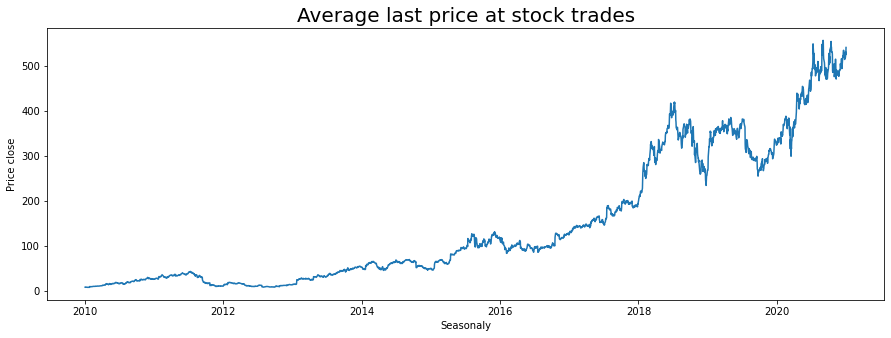

In [14]:
# plotting data

date = df['Date'].values
close  = df['Close'].values

date = np.array(date)
close = np.array(close)

plt.figure(figsize=(15,5))
plt.plot(date, close)
plt.title('Average last price at stock trades', fontsize=20)
plt.ylabel('Price close')
plt.xlabel('Seasonaly')

In [21]:
# split dataset menjadi train dan validation

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(close, date, test_size=0.2, shuffle=False)

# menampilkan hasil split

print("data train : ",len(x_train))
print("data validation : ",len(x_valid))

data train :  2215
data validation :  554


In [22]:
# menerapkan window untuk model

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [46]:
# membangun model dengan Sequential

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  # menggunakan LSTM
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [47]:
Mae = (df['Close'].max() - df['Close'].min()) * 10/100
print(Mae)

54.9531417


In [48]:
# membuat callback dengan on_epoch_end

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 54.9531417):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()


In [49]:
from keras.losses import Huber
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [50]:
history = model.fit(
    train_set,
    validation_data = validation_set,
    epochs=100,
    callbacks = [callbacks]
    )

Epoch 1/100
22/22 [==============================] - 6s 107ms/step - loss: 89.4583 - mae: 89.9583 - val_loss: 389.0706 - val_mae: 389.5706
Epoch 2/100
22/22 [==============================] - 2s 74ms/step - loss: 89.2989 - mae: 89.7989 - val_loss: 388.9645 - val_mae: 389.4645
Epoch 3/100
22/22 [==============================] - 2s 77ms/step - loss: 89.2407 - mae: 89.7407 - val_loss: 388.9308 - val_mae: 389.4308
Epoch 4/100
22/22 [==============================] - 2s 76ms/step - loss: 89.1985 - mae: 89.6985 - val_loss: 388.8881 - val_mae: 389.3881
Epoch 5/100
22/22 [==============================] - 2s 75ms/step - loss: 89.1554 - mae: 89.6554 - val_loss: 388.8436 - val_mae: 389.3436
Epoch 6/100
22/22 [==============================] - 2s 75ms/step - loss: 89.1091 - mae: 89.6091 - val_loss: 388.7906 - val_mae: 389.2906
Epoch 7/100
22/22 [==============================] - 2s 75ms/step - loss: 89.0545 - mae: 89.5545 - val_loss: 388.7134 - val_mae: 389.2134
Epoch 8/100
22/22 [==============

In [52]:
# summary

log_mae = history.history['mae']
log_loss = history.history['loss']

def view_summary(nm,la,mm):
  print(nm, ' : ', float(f'{(mm(la)):.05f}'))

def ln(opt):
  if opt == 1:
    print("_"*50)
  elif opt == 2:
    print('='*50)
  else:
    print('-'*50)

print('\n')
ln(1)
print('SUMMARY'.center(50))
ln(2)
# memanggil fungsi view_summary
view_summary('Mae',log_mae,min)
view_summary('Loss',log_loss,min)
ln(1)



__________________________________________________
                     SUMMARY                      
Mae  :  45.12283
Loss  :  44.63295
__________________________________________________
